# Fit a polynomial function which is monotonically increasing in range [f, g] by a semidefinite programming

find a least squares solution of a polynomial which is monotonically increasing in the range [f, g] and passes through some fixed points.

such a polynomial has a derivative which can be represented using SOS(sum-of-squares) of polynomials, which in turn can be represented using quadratic forms of symmetric semidefinite matrices.

this notebook shows how to fit such a polynomial to noisy data by first formulate the problem as SDP(semidefinite programming), and then solve the SDP using a convex solver: CVXOPT.

In [1]:
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [2]:
# helper function
def format_polynomial(func, coefficients, precision=''):
    s = '{}(x) = '.format(func)
    for i in range(len(coefficients)):
        p = len(coefficients) - i - 1
        if i == 0:
            s += '{{:{}}}'.format(precision).format(coefficients[p])
        else:
            s += '{{:+{}}}'.format(precision).format(coefficients[p])
        if p == 0:
            pass
        elif p == 1:
            s += 'x'
        else:
            s += 'x^{}'.format(p)
    return s
def polynomial(x, p):
    return sum(p[i] * x**i for i in range(len(p)))
def polynomial_prime(x, p): 
    return sum(i * p[i] * x**(i - 1) for i in range(1, len(p)))
def polynomial_prime_coef(p):
    return [i * p[i] for i in range(1, len(p))]

## formulate the fitting problem as a SDP and solve it using CVXOPT

In [3]:
def fit_monotonically_increasing_polynomial(dim_p, xs, ys, range_begin, range_end, fixed_xs=[], fixed_ys=[],
                                           verbose=False):
    '''
    @param dim_p        degree of the polynomial.
    @param xs           x of input data to fit.
    @param ys           y of input data to fit.
    @param range_begin  find a least square solution which is monotonically increasing in [range_begin, range_end]
    @param range_end    find a least square solution which is monotonically increasing in [range_begin, range_end]
    @param fixed_xs     x of mandatory waypoints
    @param fixed_ys     y of mandatory waypoints
    @param verbose      enable verbose outputs
    @return polynomial_coefficients. p(x) = dot(<polynomial_coefficients>, [1 x x**2 .. x**d])
    '''
    # SDP:
    # minimize_param r
    #  s.t. param = (s0 .. slast | t0 .. tlast | C | r)
    #       ||Y - Vp||**2 <= r
    #       Y = (y0 y1..), V=(1 x1^1 x1^2 .. x1^d; ..; 1 xn^1 xn^2 .. xn^d)
    #       p = (p0 p1 .. p^d) = M param
    #       p(x) = integral(p'(x)dx) + C
    #
    #       F_xi p = fixed_yi  : fixed points. F_xi = (1 fx1^1 fxn^2 .. fx1^d; ..; 1 fxn^1 fxn^2 .. fxn^d)
    assert dim_p > 0
    assert len(xs) == len(ys)
    assert len(fixed_xs) == len(fixed_ys)
    assert dim_p - len(fixed_xs) >= 0
    assert range_begin < range_end
    f, g = range_begin, range_end
    dim_d = dim_p - 1

    # index for each variable.
    # - s and t: for nonnegative quadratic function in [f, g]
    # - r: slack variable
    if dim_d % 2 == 0:
        # p'(x) = s(x) + (x - f)(g - x)t(x)
        dim_dhalf = dim_d // 2
        ns = dim_dhalf + 1
        nt = dim_dhalf - 2 + 1
    else:
        # p'(x) = (x - f)s(x) + (g - x)t(x)
        dim_dhalf = (dim_d - 1) // 2
        ns = dim_dhalf + 1
        nt = dim_dhalf + 1
    n_variables = ns**2 + nt**2 + 2
    i_s = list(range(0, ns**2))
    i_t = list(range(ns**2, ns**2 + nt**2))
    i_C, i_r = list(range(ns**2 + nt**2, n_variables))
    if verbose: print('i_s={}, i_t={}, i_C={}, i_r={}'.format(i_s, i_t, i_C, i_r))

    # min r = c' param
    c = matrix([0.0] * n_variables)
    c[i_r] = 1.0

    # define a matrix M to extract polynomial coefficients from <param>.
    # (p0 p1 .. p_d) = M param
    M = matrix(0.0, (dim_p + 1, n_variables))
    i_integral = 1 # first calc coefficient of p'(x) and then integrate to make coefficient of p(x).
    if dim_d % 2 == 0:
        # s(x)
        for i in range(ns):
            for j in range(ns):
                M[i + j + i_integral, i_s[i * ns + j]] += 1.0 / (i + j + i_integral)
        # (-x^2 + (f + g)x - fg) t(x)
        for i in range(nt):
            for j in range(nt):
                # -x^2
                M[i + j + 2 + i_integral, i_t[i * nt + j]] += -1.0 / (i + j + 2 + i_integral)
                # (f + g)x
                M[i + j + 1 + i_integral, i_t[i * nt + j]] += (f + g) / (i + j + 1 + i_integral)
                # -fg
                M[i + j + i_integral, i_t[i * nt + j]] += - f * g / (i + j + i_integral)
    else:
        # (x - f)s(x)
        for i in range(ns):
            for j in range(ns):
                # x
                M[i + j + 1 + i_integral, i_s[i * ns + j]] += 1.0 / (i + j + 1 + i_integral)
                # -f
                M[i + j + i_integral, i_s[i * ns + j]] += - f / (i + j + i_integral)
        # (g - x)t(x)
        for i in range(nt):
            for j in range(nt):
                # g
                M[i + j + i_integral, i_t[i * nt + j]] += g / (i + j + i_integral)
                # -x
                M[i + j + 1 + i_integral, i_t[i * nt + j]] += -1.0 / (i + j + 1 + i_integral)
    # integral constant.
    M[0, i_C] = 1.0
    if verbose: print('M =', M)

    # V: the Vandermonde's matrix 
    N = len(xs)
    V = matrix(0.0, (N, dim_p + 1))
    for i, x in enumerate(xs):
        for j in range(dim_p + 1):
            V[i, j] = x ** j

    VM = V * M

    # objective least squares is converted into a SDP condition using the slack variable <r>.
    #
    # s1 = mat(h1) - mat(G1 param) = [ I, V M param; V M param', r + 2 Y' V M param - Y' Y ] >= 0
    # dim(V M param) = N.
    # => dim(s1) = (N + 1)^2
    Y = matrix(ys)
    YVM = Y.T * VM
    h1 = matrix(0.0, ((N + 1), (N + 1)))
    G1 = matrix(0.0, ((N + 1) * (N + 1), n_variables))
    for i in range(N):
        # I block
        h1[i, i] = 1.0
        # V M param block
        for j in range(n_variables):
            G1[i * (N + 1) + N, j] = -VM[i, j]
            G1[N * (N + 1) + i, j] = -VM[i, j]
    # scalar block
    h1[N, N] = - Y.T * Y
    for j in range(n_variables):
        G1[N * (N + 1) + N, j] = - 2 * YVM[j]
    G1[N * (N + 1) + N, i_r] -= 1

    # required for nonnegative derivative of the polynomial in range [f, g].
    # quadratic that is nonnegative in [f, g] is represented as:
    #  f(x) = s(x) + (x-f)(g-x)t(x)
    #  where s and t are a SOS(sum-of-squares), which can be constructed from the quadratic form of symmetric semidefinite Qs, Qt.
    # s2 = Qs >= 0
    h2 = matrix(0.0, (ns, ns))
    G2 = matrix(0.0, (ns**2, n_variables))
    for i in range(ns):
        for j in range(ns):
            G2[i * ns + j, i_s[i * ns + j]] = -1.0

    # s3 = Qt >= 0
    h0 = matrix(0.0, (nt, nt))
    G0 = matrix(0.0, (nt**2, n_variables))
    for i in range(nt):
        for j in range(nt):
            G0[i * nt + j, i_t[i * nt + j]] = -1.0

    # linear constraints
    N_fixed = len(fixed_xs)
    A = matrix(0.0, (N_fixed + (ns - 1) * ns // 2 + (nt - 1) * nt // 2, n_variables))
    b = matrix(0.0, (N_fixed + (ns - 1) * ns // 2 + (nt - 1) * nt // 2, 1))
    if N_fixed > 0:
        Ap = matrix(0.0, (N_fixed, dim_p + 1))
        # Vandermonde's matrix for fixed points.
        for i, (x, y) in enumerate(zip(fixed_xs, fixed_ys)):
            for j in range(dim_p + 1):
                Ap[i, j] = x**j
            b[i] = y
        A[:N_fixed, :] = Ap * M
    # symmetry constraint for Qs
    iconstraint = N_fixed
    for i in range(ns):
        for j in range(i + 1, ns):
            A[iconstraint, i_s[i * ns + j]] = 1.0
            A[iconstraint, i_s[j * ns + i]] = -1.0
            b[iconstraint] = 0.0
            iconstraint += 1
    # symmetry constraint for Qt
    for i in range(nt):
        for j in range(i + 1, nt):
            A[iconstraint, i_t[i * nt + j]] = 1.0
            A[iconstraint, i_t[j * nt + i]] = -1.0
            b[iconstraint] = 0.0
            iconstraint += 1


    # solve the SDP.
    result = solvers.sdp(c, Gs=[G0, G1, G2], hs=[h0, h1, h2], A=A, b=b, verbose=verbose)
    Qs = np.array(result['x'][:ns * ns]).reshape(ns, ns)
    Qt = np.array(result['x'][ns * ns:ns * ns + nt * nt]).reshape(nt, nt)
    C, r = result['x'][ns * ns + nt * nt:]
    if verbose: print('Qs =', Qs)
    if verbose: print('Qt =', Qt)
    if verbose: print('C =', C)
    if verbose: print('r =', r)

    polynomial_coefficients = np.array(M * result['x']).ravel()

    if verbose: IPython.display.display(result)
    return polynomial_coefficients

# Cubic demo

## create noisy datapoints from the ground truth

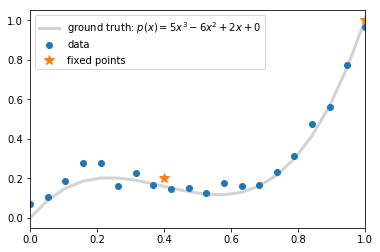

In [4]:
f, g = 0, 1
#gt = [0, 2.2, -1.9, 0.7] # another polynomial. nonnegative derivative in [0, 1]
gt = [0, 2, -6, 5] # ground truth. slightly negative derivative in [0, 1]
def target_func(x): return gt[3] * x**3 + gt[2] * x**2 + gt[1] * x + gt[0]

np.random.seed(0)
xs = np.linspace(f, g, 20)
ts = target_func(xs)
ys = ts + np.random.randn(*xs.shape) * 0.04

# fitted function must pass through these points.
fixed_xs = [0.4, 1]
fixed_ys = [0.2, 1]

fig, ax = plt.subplots(1, 1)
ax.plot(xs, ts, '-', linewidth=3, color='lightgray', label='ground truth: ${}$'.format(
    format_polynomial('p', gt)))
ax.plot(xs, ys, 'o', label='data')
ax.plot(fixed_xs, fixed_ys, '*', ms=10, label='fixed points')
ax.set_xlim(f, g)
ax.legend(loc='best', fancybox=True)
plt.show()

In [5]:
p = fit_monotonically_increasing_polynomial(3, xs, ys, f, g, fixed_xs, fixed_ys, verbose=True)

print('found a polynomial:')
IPython.display.display(IPython.display.Math(format_polynomial('p', p)))
print('ground truth:')
IPython.display.display(IPython.display.Math(format_polynomial('p', gt)))

i_s=[0, 1, 2, 3], i_t=[], i_C=4, i_r=5
M = [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00]
[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  5.00e-01  5.00e-01  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  0.00e+00  3.33e-01  0.00e+00  0.00e+00]

     pcost       dcost       gap    pres   dres   k/t
 0: -3.7866e+00 -2.1128e+01  9e+01  2e+00  2e+01  1e+00
 1: -2.7825e-01 -6.8554e+00  3e+01  1e+00  7e+00  2e+00
 2: -1.8597e-01 -7.0852e-01  2e+00  2e-01  1e+00  7e-01
 3: -2.7837e-01 -7.4899e-01  2e+00  1e-01  7e-01  4e-01
 4:  7.5407e-02 -5.7391e-02  4e-01  2e-02  1e-01  4e-02
 5:  9.4948e-02  4.3027e-02  2e-01  9e-03  5e-02  1e-02
 6:  1.1142e-01  1.0396e-01  2e-02  1e-03  8e-03  2e-03
 7:  1.1521e-01  1.1488e-01  1e-03  5e-05  3e-04  6e-05
 8:  1.1541e-01  1.1540e-01  5e-05  2e-06  2e-05  3e-06
 9:  1.1542e-01  1.1542e-01  2e-06  1e-07  8e-07  1e-07
10:  1.1542e-01  1.1542e-01  2e-07  1e-08  6e-08  1e-08
11:  1.1542e-01  1.1542e-01  3e-08  2e

{'dual infeasibility': 9.333818024283282e-09,
 'dual objective': 0.11542450198907644,
 'dual slack': 2.279604234388865e-11,
 'gap': 2.7978401345649045e-08,
 'iterations': 11,
 'primal infeasibility': 1.5082572227295314e-09,
 'primal objective': 0.11542451159954713,
 'primal slack': 2.6035411344814823e-10,
 'relative gap': 2.423956860415726e-07,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 'sl': <0x1 matrix, tc='d'>,
 'ss': [<0x0 matrix, tc='d'>, <21x21 matrix, tc='d'>, <2x2 matrix, tc='d'>],
 'status': 'optimal',
 'x': <6x1 matrix, tc='d'>,
 'y': <3x1 matrix, tc='d'>,
 'zl': <0x1 matrix, tc='d'>,
 'zs': [<0x0 matrix, tc='d'>, <21x21 matrix, tc='d'>, <2x2 matrix, tc='d'>]}

found a polynomial:


<IPython.core.display.Math object>

ground truth:


<IPython.core.display.Math object>

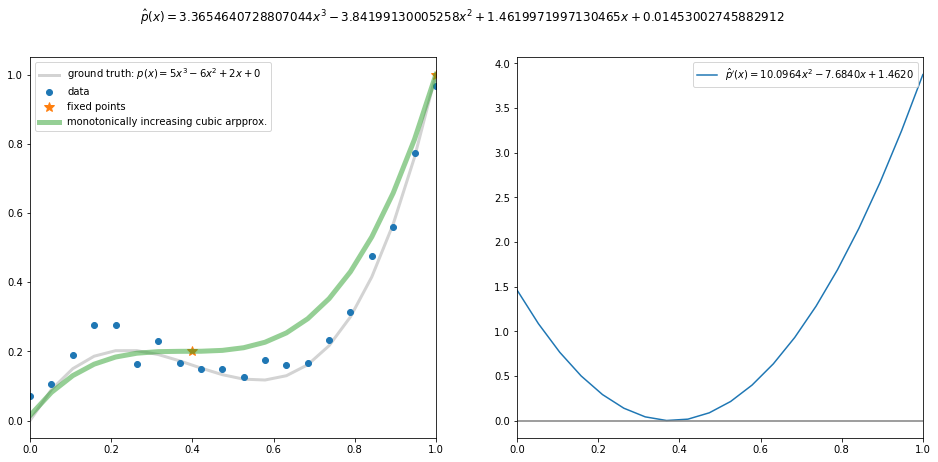

In [6]:
# visualize
fs = polynomial(xs, p)
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(xs, ts, '-', linewidth=3, color='lightgray', label='ground truth: ${}$'.format(
    format_polynomial('p', gt)))
ax[0].plot(xs, ys, 'o', label='data')
ax[0].plot(fixed_xs, fixed_ys, '*', ms=10, label='fixed points')
ax[0].plot(xs, fs, '-', linewidth=5, alpha=0.5, label='monotonically increasing cubic arpprox.')
ax[0].set_xlim(f, g)
ax[0].legend(loc='best', fancybox=True)
ax[1].plot(xs, polynomial_prime(xs, p), label='${}$'.format(
    format_polynomial(r'\hat{{p}}^\prime', polynomial_prime_coef(p), '.4f')))
ax[1].axhline(y=0, color='gray')
ax[1].set_xlim(f, g)
ax[1].legend(loc='best', fancybox=True)
fig.suptitle('${}$'.format(format_polynomial(r'\hat{{p}}', p)))
plt.show()

# Quartic demo

In [7]:
f, g = 1, 3
gt = [-5, -4, -0.2, 4.2, -1.05] # ground truth. slightly negative derivative in [0, 1]
def target_func(x): return gt[4] * x**4 + gt[3] * x**3 + gt[2] * x**2 + gt[1] * x + gt[0]

np.random.seed(0)
xs = np.linspace(f, g, 30)
ts = target_func(xs)
ys = ts + np.random.randn(*xs.shape) * 0.7

# fitted function must pass through these points.
fixed_xs = [1.5, 2.7]
fixed_ys = [-2.5, 8.0]

# fit
p = fit_monotonically_increasing_polynomial(4, xs, ys, f, g, fixed_xs, fixed_ys, verbose=True)

print('found a polynomial:')
IPython.display.display(IPython.display.Math(format_polynomial('p', p)))
print('ground truth:')
IPython.display.display(IPython.display.Math(format_polynomial('p', gt)))

i_s=[0, 1, 2, 3], i_t=[4, 5, 6, 7], i_C=8, i_r=9
M = [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[-1.00e+00  0.00e+00  0.00e+00  0.00e+00  3.00e+00  0.00e+00  0.00e+00 ... ]
[ 5.00e-01 -5.00e-01 -5.00e-01  0.00e+00 -5.00e-01  1.50e+00  1.50e+00 ... ]
[ 0.00e+00  3.33e-01  3.33e-01 -3.33e-01  0.00e+00 -3.33e-01 -3.33e-01 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  2.50e-01  0.00e+00  0.00e+00  0.00e+00 ... ]

     pcost       dcost       gap    pres   dres   k/t
 0: -4.7252e+02  1.2365e+04  1e+04  1e-01  3e+04  1e+00
 1: -3.0999e+03  5.9984e+04  4e+05  6e-01  1e+05  4e+02
 2: -3.0662e+03  2.0711e+04  1e+05  2e-01  6e+04  4e+02
 3: -4.7599e+02  2.8987e+04  2e+05  3e-01  7e+04  9e+02
 4: -9.2104e+02  3.6123e+03  1e+04  4e-02  1e+04  2e+02
 5: -9.7938e+02  8.4798e+02  5e+03  2e-02  4e+03  1e+02
 6: -5.7899e+02  6.0351e+02  3e+03  1e-02  3e+03  5e+01
 7: -5.1963e+02  3.8640e+01  1e+03  5e-03  1e+03  3e+01
 8: -2.5511e+02 -2.1206e+01  7e+02  2e-03  5e+02  2e+01
 9:

{'dual infeasibility': 1.3885048334415277e-08,
 'dual objective': 37.402258384512386,
 'dual slack': 7.658096071697616e-13,
 'gap': 1.6513858050331832e-08,
 'iterations': 21,
 'primal infeasibility': 1.4175872951804765e-11,
 'primal objective': 37.40225837828196,
 'primal slack': 7.224716638372202e-13,
 'relative gap': 4.4152034565832335e-10,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 'sl': <0x1 matrix, tc='d'>,
 'ss': [<2x2 matrix, tc='d'>, <31x31 matrix, tc='d'>, <2x2 matrix, tc='d'>],
 'status': 'optimal',
 'x': <10x1 matrix, tc='d'>,
 'y': <4x1 matrix, tc='d'>,
 'zl': <0x1 matrix, tc='d'>,
 'zs': [<2x2 matrix, tc='d'>, <31x31 matrix, tc='d'>, <2x2 matrix, tc='d'>]}

found a polynomial:


<IPython.core.display.Math object>

ground truth:


<IPython.core.display.Math object>

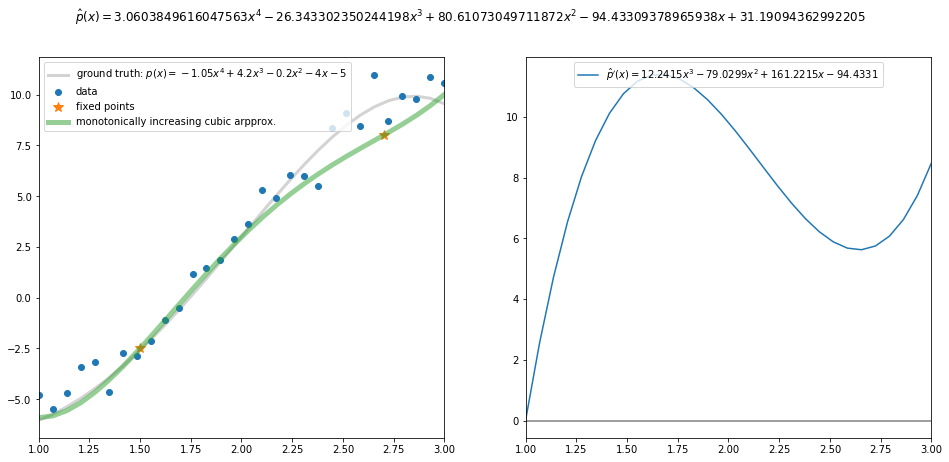

In [8]:
# visualize
fs = polynomial(xs, p)
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(xs, ts, '-', linewidth=3, color='lightgray', label='ground truth: ${}$'.format(
    format_polynomial('p', gt)))
ax[0].plot(xs, ys, 'o', label='data')
ax[0].plot(fixed_xs, fixed_ys, '*', ms=10, label='fixed points')
ax[0].plot(xs, fs, '-', linewidth=5, alpha=0.5, label='monotonically increasing cubic arpprox.')
ax[0].set_xlim(f, g)
ax[0].legend(loc='upper left', fancybox=True)
ax[1].plot(xs, polynomial_prime(xs, p), label='${}$'.format(
    format_polynomial(r'\hat{{p}}^\prime', polynomial_prime_coef(p), '.4f')))
ax[1].axhline(y=0, color='gray')
ax[1].set_xlim(f, g)
ax[1].legend(loc='upper center', fancybox=True)
fig.suptitle('${}$'.format(format_polynomial(r'\hat{{p}}', p)))
plt.show()

# Reference
 * CVXOPT semidefinite programming: http://cvxopt.org/userguide/coneprog.html#semidefinite-programming
 * use a quadratic objective in SDP: https://math.stackexchange.com/questions/2256241/writing-a-convex-quadratic-program-qp-as-a-semidefinite-program-sdp
 * sums of squares for nonnegative polynominals: http://stellar.mit.edu/S/course/6/sp10/6.256/courseMaterial/topics/topic2/lectureNotes/lecture-10/lecture-10.pdf
 * monotonically increasing polynomials: https://math.stackexchange.com/questions/60610/polynomial-fitting-where-polynomial-must-be-monotonically-increasing
 